# Dataflow

AnnData (PY) is used as the datastructure to handle the single cell data.

Anndata2ri is used to convert AnnData, python object, to SingleCellExperiment object, R object, which can be processed by Seurat that runs in python enabled by rpy2.

Seurat is used for data normalization (`SCTransform`), and integration of different stages (`FindIntegrationAnchors` and `IntegrateData`).

Processed data will be transfered back to AnnData object in python.

Scanpy is used for data visualization due to its rich plotting functionalities.

# Setup

Setting up the above workflow in jupyter using Conda

```
# R=4.0.5 is required for compatibilities between Anndata2ri=1.0.5 and rpy2=3.4.2
# see https://github.com/theislab/anndata2ri/issues/63
conda create -n scRNA -c conda-forge r-essentials r-base=4.0
conda activate scRNA

# install seurat
# start R
install.packages("Seurat")
if (!requireNamespace("BiocManager", quietly = TRUE)) install.packages("BiocManager")
BiocManager::install("glmGamPoi")

# Anndata, Anndata2ri, and Scanpy
pip install 'rpy2==3.4.2'
pip install anndata2ri
conda install seaborn scikit-learn statsmodels numba pytables
conda install -c conda-forge python-igraph leidenalg 
conda install -c bioconda scanpy

# jupyter
conda install ipykernel nb_black 
python -m ipykernel install --user --name scrna --display-name "scrna"
```

In [2]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import scanpy as sc
import numpy as np
import pandas as pd
import anndata as ad
from rpy2.robjects import r, globalenv
from anndata2ri.py2r import py2rpy_anndata
from scipy.sparse import coo_matrix, csr_matrix

In [4]:
import matplotlib.pyplot as plt

In [5]:
# Activate the anndata2ri conversion between SingleCellExperiment and AnnData
# anndata2ri.activate()
# Loading the rpy2 extension enables cell magic to be used
# This runs R code in jupyter notebook cells
%load_ext rpy2.ipython

# sc.logging.print_versions()
sc.settings.verbosity = 3

In [6]:
%%R
library(Seurat)
library(repr)
options(repr.plot.width=15, repr.plot.height=8)

R[write to console]: Attaching SeuratObject



In [7]:
def anndata_to_seurat_object(ad, r_var_name):
    """
    Convert AnnData python object to seurat object, named r_var_name in R
    """
    globalenv[r_var_name] = py2rpy_anndata(ad)
    globalenv[r_var_name] = r(f"as.Seurat({r_var_name}, counts='X', data=NULL)")
    print(r(f"repr({r_var_name})")[0])


def load_anndata(data_path, cell_meta_data=None, sep=","):
    """
    Assume count table in cell-gene orgainzation, different from R fashion; that is,
    after read by pandas, the first columns will be the cell identifiers and the header will be gene names
    """
    sc_data = pd.read_csv(data_path, sep=sep)
    adata = ad.AnnData(csr_matrix(sc_data.iloc[:, 1:]), dtype=np.float32)
    # observe dimension
    adata.obs_names = sc_data.iloc[:, 0].values
    if cell_meta_data is None:
        # need this place holder field in order for successful convertion to seurat objec
        adata.obs["Cell_ID"] = [f"Cell_{i:d}" for i in range(adata.n_obs)]
    else:
        for name, meta_data in cell_meta_data.items():
            adata.obs[name] = meta_data

    # var dimension
    adata.var_names = sc_data.columns[1:].values

    # calculate qc stats
    adata.var["mt"] = adata.var_names.str.startswith(
        "MT-"
    )  # annotate the group of mitochondrial genes as 'mt'
    sc.pp.calculate_qc_metrics(
        adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
    )
    adata.obs["complexity"] = np.log10(adata.obs.n_genes_by_counts) / np.log10(
        adata.obs.total_counts
    )

    # plot to help determine cell filter conditions
    sc.pl.violin(
        adata,
        ["n_genes_by_counts", "total_counts", "pct_counts_mt", "complexity"],
        jitter=0.4,
        multi_panel=True,
    )
    # sc.pl.violin(
    #     adata,
    #     ["n_genes_by_counts", "total_counts", "pct_counts_mt", "complexity"],
    #     jitter=0.4,
    #     log=True,
    #     multi_panel=True,
    # )
    return adata

# E8.5

In [8]:
e875_data_files = {
    "E8.75ParE_1": "singlecell_counts/E8.75/E8.75_ParE/GSM3494351_Lib7-1_E8.75_ParE_counts.csv.gz",
    "E8.75VE_1": "singlecell_counts/E8.75/E8.75_VE_gfp/GSM3494355_Lib11-1_E8.75_GFP+_counts.csv.gz",
    "E8.75YsE_1": "singlecell_counts/E8.75/E8.75_YsE/GSM3494353_Lib8-1_E8.75_YsE_counts.csv.gz",
    "E8.75DE_1": "singlecell_counts/E8.75/E8.75_DE_gfpNeg/GSM3494357_Lib12-1_E8.75_GFP-_counts.csv.gz",
}

## DE

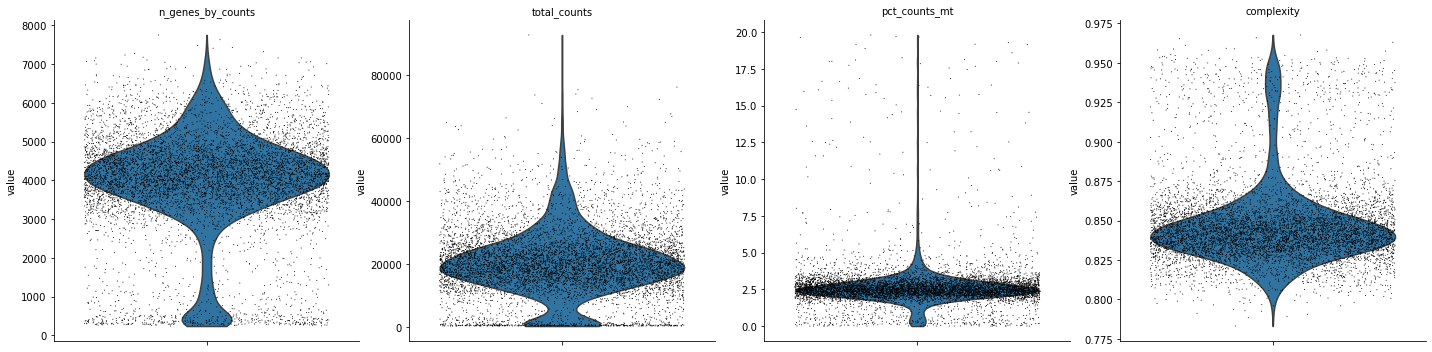

AnnData object with n_obs × n_vars = 7521 × 19730
    obs: 'Stage', 'Cell_Type', 'Rep', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'complexity'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [9]:
DE_adata = load_anndata(
    e875_data_files["E8.75DE_1"], {"Stage": "E8.75", "Cell_Type": "DE", "Rep": 1}
)
DE_adata

In [10]:
DE_adata = DE_adata[
    (DE_adata.obs.n_genes_by_counts > 500)
    & (DE_adata.obs.n_genes_by_counts < 6000)
    & (DE_adata.obs.total_counts > 2000)
    & (DE_adata.obs.complexity > 0.8)
    & (DE_adata.obs.pct_counts_mt < 5)
]
DE_adata

View of AnnData object with n_obs × n_vars = 6621 × 19730
    obs: 'Stage', 'Cell_Type', 'Rep', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'complexity'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

## ParE

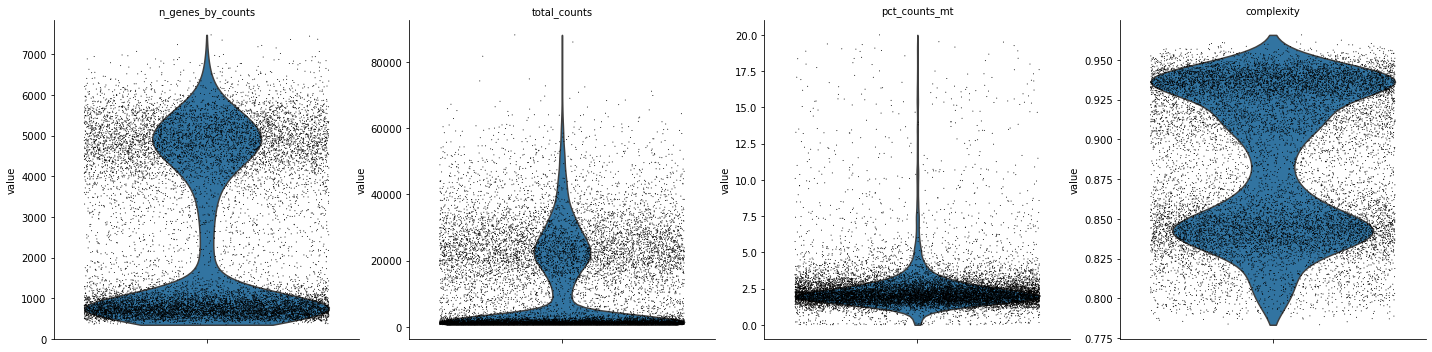

AnnData object with n_obs × n_vars = 14085 × 19579
    obs: 'Stage', 'Cell_Type', 'Rep', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'complexity'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [11]:
ParE_adata = load_anndata(
    e875_data_files["E8.75ParE_1"], {"Stage": "E8.75", "Cell_Type": "ParE", "Rep": 1}
)
ParE_adata

In [12]:
ParE_adata = ParE_adata[
    (ParE_adata.obs.n_genes_by_counts > 1500)
    & (ParE_adata.obs.n_genes_by_counts < 6000)
    & (ParE_adata.obs.total_counts > 3500)
    & (ParE_adata.obs.complexity > 0.825)
    & (ParE_adata.obs.pct_counts_mt < 5)
]
ParE_adata

View of AnnData object with n_obs × n_vars = 5528 × 19579
    obs: 'Stage', 'Cell_Type', 'Rep', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'complexity'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

## VE

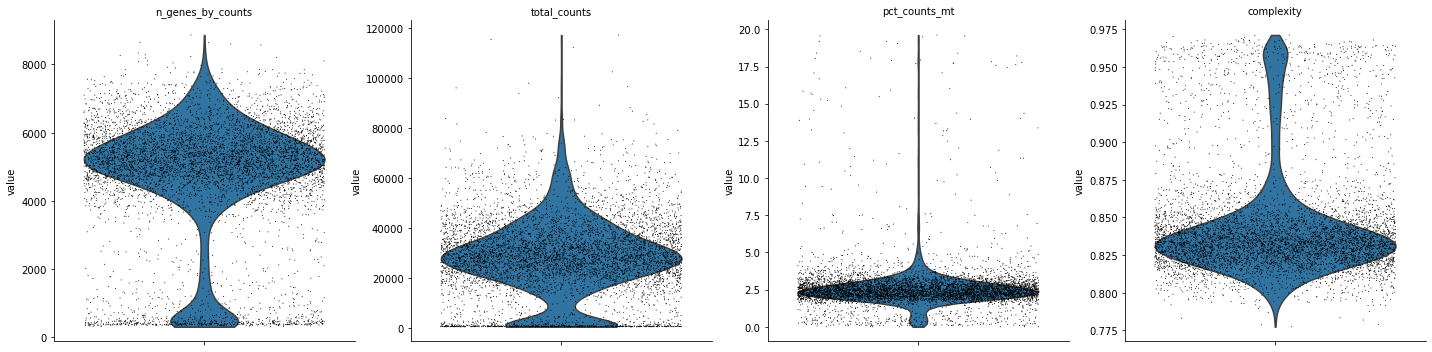

AnnData object with n_obs × n_vars = 6370 × 20153
    obs: 'Stage', 'Cell_Type', 'Rep', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'complexity'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [13]:
VE_adata = load_anndata(
    e875_data_files["E8.75VE_1"], {"Stage": "E8.75", "Cell_Type": "VE", "Rep": 1}
)
VE_adata

In [14]:
VE_adata = VE_adata[
    (VE_adata.obs.n_genes_by_counts > 500)
    & (VE_adata.obs.n_genes_by_counts < 7000)
    & (VE_adata.obs.total_counts > 2000)
    & (VE_adata.obs.complexity > 0.80)
    & (VE_adata.obs.pct_counts_mt < 5)
]
VE_adata

View of AnnData object with n_obs × n_vars = 5400 × 20153
    obs: 'Stage', 'Cell_Type', 'Rep', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'complexity'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

## YsE

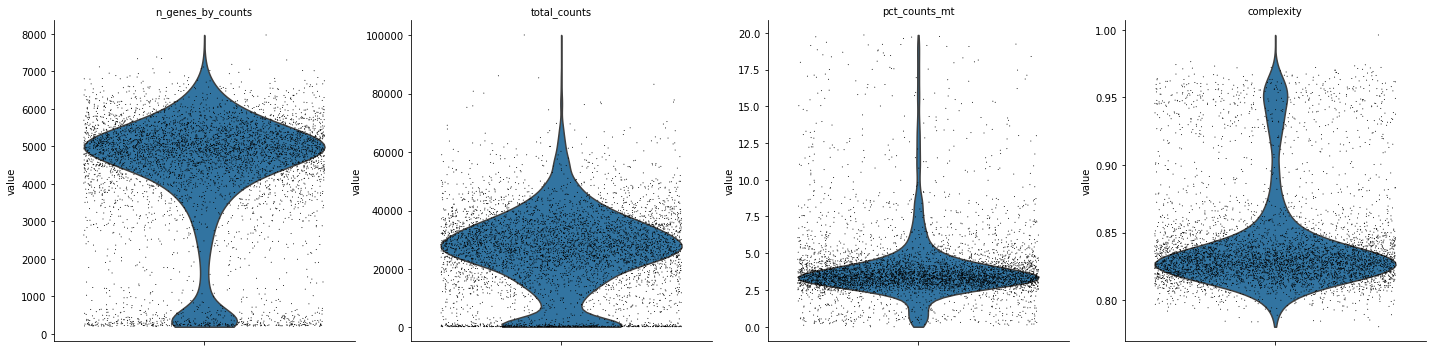

AnnData object with n_obs × n_vars = 5138 × 17511
    obs: 'Stage', 'Cell_Type', 'Rep', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'complexity'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [15]:
YsE_adata = load_anndata(
    e875_data_files["E8.75YsE_1"], {"Stage": "E8.75", "Cell_Type": "YsE", "Rep": 1}
)
YsE_adata

In [16]:
YsE_adata = YsE_adata[
    (YsE_adata.obs.n_genes_by_counts > 500)
    & (YsE_adata.obs.n_genes_by_counts < 6500)
    & (YsE_adata.obs.total_counts > 2000)
    & (YsE_adata.obs.complexity > 0.80)
    & (YsE_adata.obs.pct_counts_mt < 5)
]
YsE_adata

View of AnnData object with n_obs × n_vars = 3866 × 17511
    obs: 'Stage', 'Cell_Type', 'Rep', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'complexity'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [17]:
e875_adata = ad.concat([DE_adata, VE_adata, ParE_adata, YsE_adata], join="outer")
e875_adata.obs_names_make_unique()
e875_adata

/home/coco/miniconda3/envs/scRNA/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 21415 × 22025
    obs: 'Stage', 'Cell_Type', 'Rep', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'complexity'

In [18]:
anndata_to_seurat_object(e875_adata, "e875_seurat")

An object of class Seurat 
22025 features across 21415 samples within 1 assay 
Active assay: originalexp (22025 features, 0 variable features)


In [19]:
%%R
# cell cycle
s.genes <- cc.genes$s.genes
g2m.genes <- cc.genes$g2m.genes
e875_seurat <- CellCycleScoring(e875_seurat, s.features = s.genes, g2m.features = g2m.genes, set.ident = FALSE)
# e875_seurat$CC.Difference <- e875_seurat$S.Score - e875_seurat$G2M.Score

R[write to console]: Warning:
R[write to console]:  The following features are not present in the object: MLF1IP, not searching for symbol synonyms



In [20]:
%%R
e875_seurat <- SCTransform(e875_seurat, assay="originalexp", verbose = FALSE, method = "glmGamPoi") #, vars.to.regress = c("S.Score", "G2M.Score"))
e875_seurat

An object of class Seurat 
41367 features across 21415 samples within 2 assays 
Active assay: SCT (19342 features, 3000 variable features)
 1 other assay present: originalexp


R[write to console]: Warning:
R[write to console]:  The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session

R[write to console]: Spectral initialization failed to converge, using random initialization instead



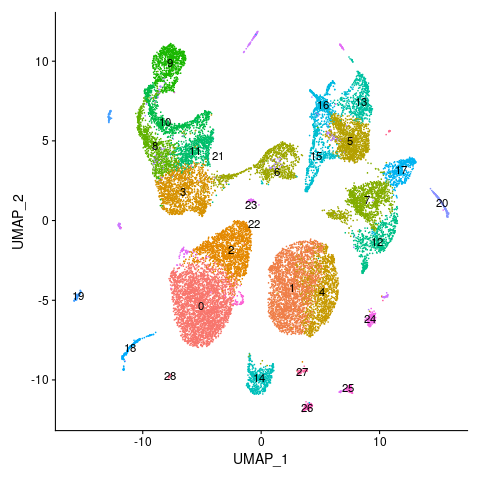

In [21]:
%%R
# These are now standard steps in the Seurat workflow for visualization and clustering
e875_seurat <- RunPCA(e875_seurat, verbose = FALSE)
e875_seurat <- RunUMAP(e875_seurat, dims = 1:30, verbose = FALSE, n.neighbors=25, min.dist=0.4, metric="correlation")

e875_seurat <- FindNeighbors(e875_seurat, dims = 1:30, verbose = FALSE)
e875_seurat <- FindClusters(e875_seurat, verbose = FALSE)
DimPlot(e875_seurat, label = TRUE) + NoLegend()

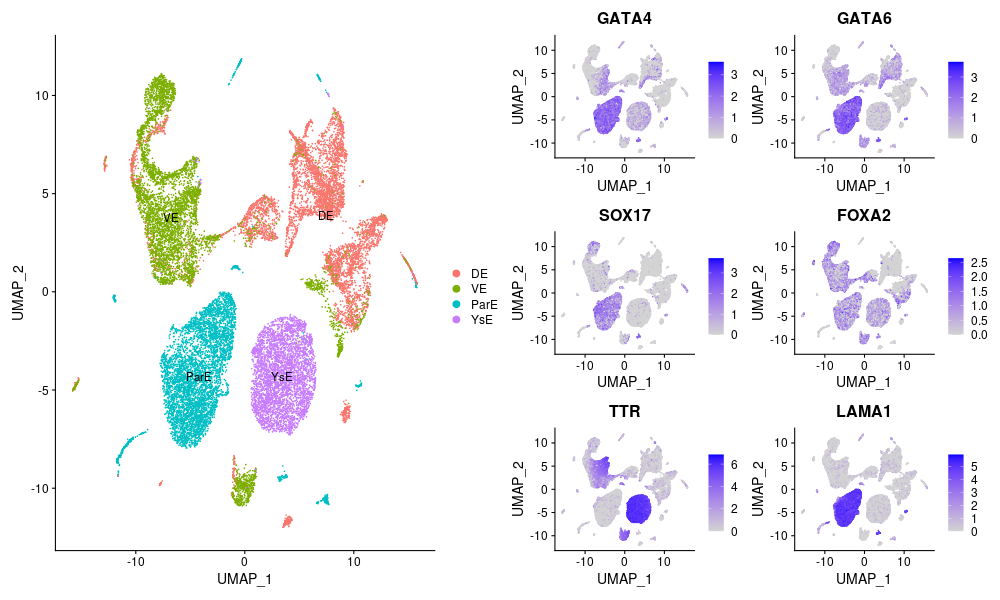

In [39]:
%%R -w 1000 -h 600
par(mfrow=c(1,2))
Idents(e875_seurat) <- "Cell_Type"
plot1 = DimPlot(e875_seurat, label = TRUE)
plot2 = FeaturePlot(e875_seurat, features=c("GATA4", "GATA6", "SOX17", "FOXA2", "TTR","LAMA1"))
plot1 + plot2

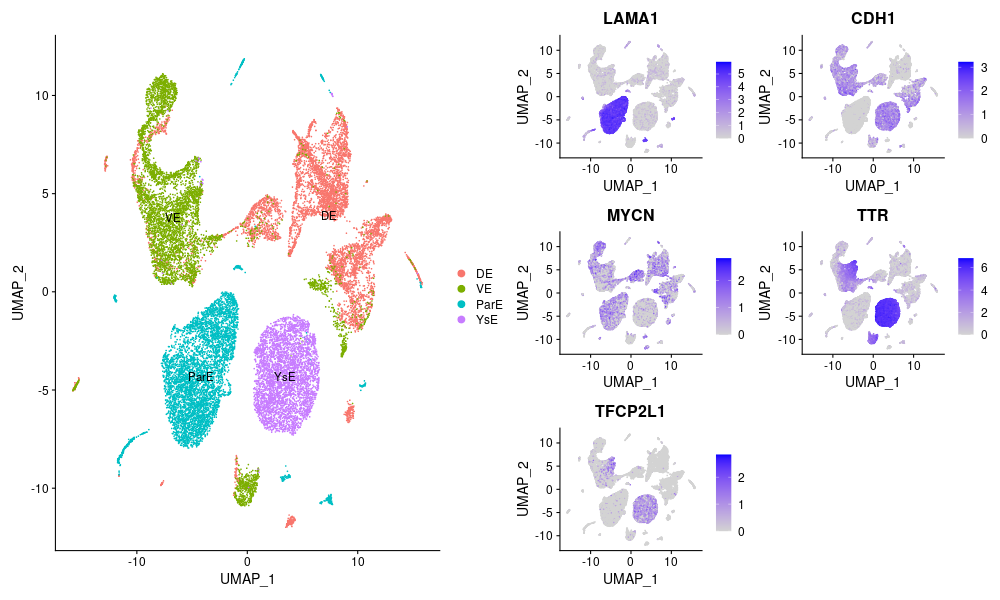

In [32]:
%%R -w 1000 -h 600
par(mfrow=c(1,2))
Idents(e875_seurat) <- "Cell_Type"
plot1 = DimPlot(e875_seurat, label = TRUE)
plot2 = FeaturePlot(e875_seurat, features=c("LAMA1", "CDH1", "MYCN", "TTR", "TFCP2L1"))
plot1 + plot2